In [1]:
import os
from PIL import Image
import torch
import numpy as np

def read_images(folder_path):
    image_list = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.png'):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert('L')  # Assuming grayscale images
            img = torch.tensor(np.array(img), dtype=torch.float32) / 255.0
            img = img.unsqueeze(0)  # Add channel dimension
            image_list.append(img)
    
    images = torch.stack(image_list)
    return images

# Example usage
folder_path = 'sampled_images'
images = read_images(folder_path)
print(f"Loaded {len(images)} images with shape {images.shape}")


Loaded 1000 images with shape torch.Size([1000, 1, 16, 16])


In [2]:
from ddpm_conditional import CustomImageFolder
from torchvision import datasets, transforms

transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Ensure the image is single-channel grayscale
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize for grayscale images
])

dataset = CustomImageFolder("data/train", transform=transform)


In [3]:
from torch.utils.data import Subset, DataLoader
import numpy as np

# Assuming 'dataset' is your CustomImageFolder dataset
total_samples = len(dataset)
subset_size = int(0.001 * total_samples)  # 1% of the total samples

# Generate random indices for selecting a subset
indices = np.random.choice(total_samples, subset_size, replace=False)

# Create a subset of the dataset using the random indices
subset_dataset = Subset(dataset, indices)

# Create a DataLoader for the subset dataset if needed
subset_dataloader = DataLoader(subset_dataset, shuffle=True)

# Use the subset_dataset for further processing


In [4]:
from tqdm import tqdm
imgs_without_labels = []
for i in tqdm(range(len(subset_dataset))):
    tmp_img = dataset[i][0]
    imgs_without_labels.append(tmp_img)


100%|██████████| 240/240 [00:00<00:00, 3372.20it/s]


In [5]:
predicted_imgs = images
original_imgs = imgs_without_labels
original_imgs = torch.stack([torch.tensor(arr).clone().detach() for arr in original_imgs])

print(predicted_imgs.shape)
print(original_imgs.shape)

torch.Size([1000, 1, 16, 16])
torch.Size([240, 1, 16, 16])


/tmp/ipykernel_6321/798569607.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  original_imgs = torch.stack([torch.tensor(arr).clone().detach() for arr in original_imgs])


In [6]:
import numpy as np
import torch
from torchvision import transforms
from torchvision.models import inception_v3
from torch.nn.functional import adaptive_avg_pool2d
from scipy.linalg import sqrtm

# Function to convert grayscale to RGB
def convert_grayscale_to_rgb(images):
    return np.stack([images] * 3, axis=-1)

# Function to resize images
def resize_images(images, size=(299, 299)):
    pil_images = []
    for image in images:
        pil_image = transforms.ToPILImage()(image)
        pil_image = transforms.Resize(size)(pil_image)
        pil_images.append(pil_image)
    tensor_images = []
    for pil_image in pil_images:
        tensor_image = transforms.ToTensor()(pil_image)
        tensor_images.append(tensor_image)
    normalized_images = []
    for tensor_image in tensor_images:
        normalized_image = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(tensor_image)
        normalized_images.append(normalized_image)
    return torch.stack(normalized_images)







In [7]:
# Convert grayscale images to RGB
original_imgs = convert_grayscale_to_rgb(original_imgs)
predicted_imgs = convert_grayscale_to_rgb(predicted_imgs)
original_imgs = original_imgs[:, 0, :, :, :]
predicted_imgs = predicted_imgs[:, 0, :, :, :]


In [8]:

# Resize images to 299x299
original_imgs = resize_images(original_imgs)
predicted_imgs = resize_images(predicted_imgs)
print(original_imgs.shape)
print(predicted_imgs.shape)

torch.Size([240, 3, 299, 299])
torch.Size([1000, 3, 299, 299])


03:16:47 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
03:16:47 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
03:16:47 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
03:16:47 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
03:16:47 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


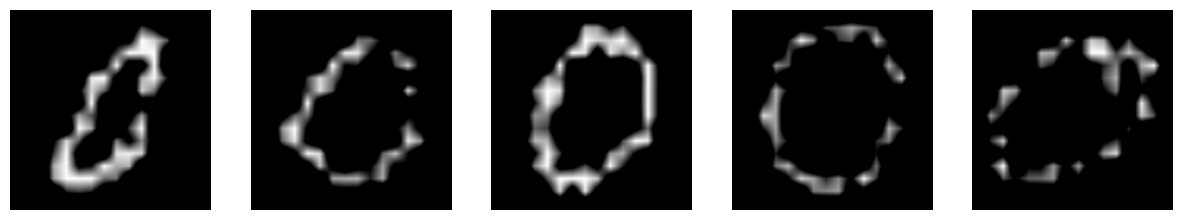

03:16:47 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
03:16:47 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
03:16:47 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
03:16:47 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
03:16:47 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


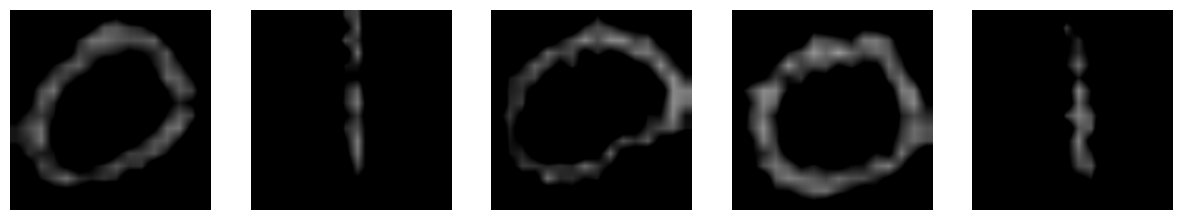

In [9]:
import matplotlib.pyplot as plt

# Define a function to plot images
def plot_images(images, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(images[i].permute(1, 2, 0))
        axes[i].axis('off')
    plt.show()

# Assuming 'original_imgs' and 'predicted_imgs' are tensors of shape (N, C, H, W)
# where N is the number of images, C is the number of channels, and H, W are the height and width
plot_images(original_imgs)
plot_images(predicted_imgs)

In [10]:
import os
import torch
import numpy as np
from torchvision.utils import save_image
from torchvision.transforms import ToTensor

# Function to save images to a directory
def save_images(images, dir_path):
    os.makedirs(dir_path, exist_ok=True)
    for i, img in enumerate(images):
        img_path = os.path.join(dir_path, f"{i}.png")
        save_image(img, img_path)

# Convert numpy arrays to tensors
# original_imgs = torch.tensor(original_imgs).permute(0, 3, 1, 2)
# predicted_imgs = torch.tensor(predicted_imgs).permute(0, 3, 1, 2)

# Save images to directories
save_images(original_imgs, 'real_images')
save_images(predicted_imgs, 'predicted_images')

In [11]:
import torch
from pytorch_fid.fid_score import calculate_fid_given_paths

# Paths to the directories containing real and fake images
paths = ['real_images', 'predicted_images']

# Calculate FID score
fid_value = calculate_fid_given_paths(paths, batch_size=50, device=torch.device('cuda'), dims=2048)
print(f'FID Score: {fid_value}')

100%|██████████| 20/20 [00:04<00:00,  4.53it/s]


FID Score: 95.19691305889057
